## task01 :使用rnn模型的lstm和gru以及基本rnn模型的三种模型对人脸数据集进行模型比对并且1绘制相关图形

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import 

# 设置随机种子保证可重复性
torch.manual_seed(42)
np.random.seed(42)

# 加载Olivetti Faces数据集
faces = fetch_olivetti_faces()
X = faces.images
y = faces.target

# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 自定义数据集类
class FaceDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 定义转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 创建数据集和数据加载器
train_dataset = FaceDataset(X_train, y_train, transform=transform)
test_dataset = FaceDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义三种RNN模型
class BasicRNN(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=2, num_classes=40):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # 输入形状: (batch_size, seq_len, input_size)
        # 将图像展平为序列 (64x64 -> 64序列，每个64特征)
        x = x.view(x.size(0), -1, 64)  # 假设原始图像是64x64
        
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播RNN
        out, _ = self.rnn(x, h0)
        
        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=2, num_classes=40):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1, 64)  # 展平为序列
        
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=2, num_classes=40):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1, 64)  # 展平为序列
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 训练和评估函数
def train_and_evaluate(model, train_loader, test_loader, num_epochs=40, model_name='RNN'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 记录训练过程中的指标
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # 计算平均训练损失
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    return train_losses, test_accuracies

# 创建模型实例
basic_rnn = BasicRNN()
lstm_model = LSTMModel()
gru_model = GRUModel()

# 训练并评估三个模型
print("Training Basic RNN...")
rnn_train_loss, rnn_test_acc = train_and_evaluate(basic_rnn, train_loader, test_loader, model_name='Basic RNN')

print("\nTraining LSTM...")
lstm_train_loss, lstm_test_acc = train_and_evaluate(lstm_model, train_loader, test_loader, model_name='LSTM')

print("\nTraining GRU...")
gru_train_loss, gru_test_acc = train_and_evaluate(gru_model, train_loader, test_loader, model_name='GRU')

# 绘制训练损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_train_loss, label='Basic RNN')
plt.plot(lstm_train_loss, label='LSTM')
plt.plot(gru_train_loss, label='GRU')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制测试准确率曲线
plt.subplot(1, 2, 2)
plt.plot(rnn_test_acc, label='Basic RNN')
plt.plot(lstm_test_acc, label='LSTM')
plt.plot(gru_test_acc, label='GRU')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# 保存模型
torch.save(basic_rnn.state_dict(), 'basic_rnn_face.pth')
torch.save(lstm_model.state_dict(), 'lstm_face.pth')
torch.save(gru_model.state_dict(), 'gru_face.pth')

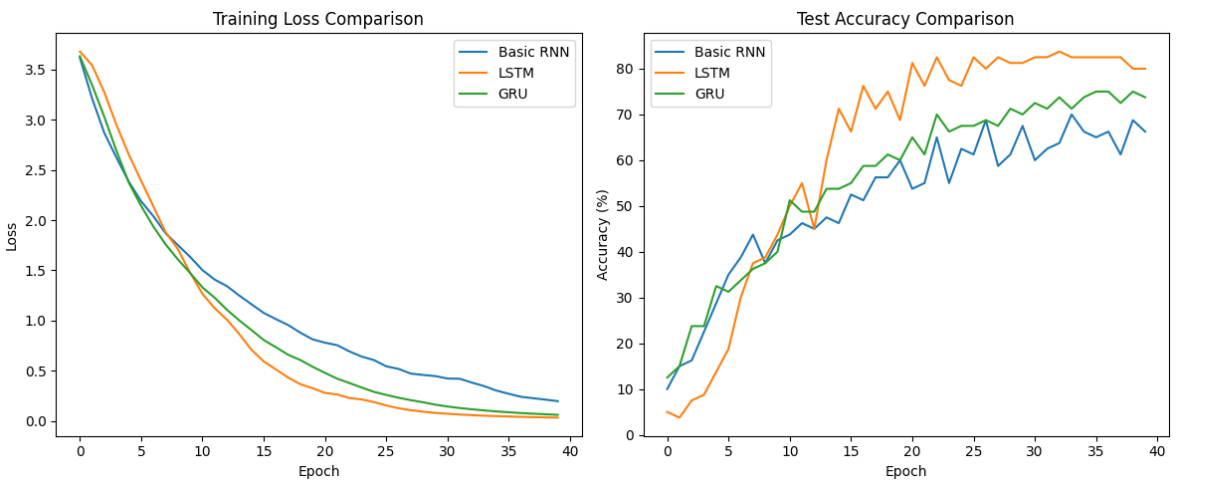

## task02 使用weather数据集进行天气预测

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
# 设置随机种子保证可重复性
np.random.seed(42)

# 加载数据集
data_path = '/kaggle/input/weatherww2'
print("数据集内容:", os.listdir(data_path))

# 尝试找到CSV文件
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("未找到CSV文件")

data_file = os.path.join(data_path, csv_files[0])
print(f"\n使用数据文件: {data_file}")

# 加载并预处理数据
try:
    # 尝试读取CSV文件
    df = pd.read_csv(data_file, parse_dates=['Date'], index_col='Date')

    # 自动检测温度列
    temp_cols = ['temp_max', 'TMAX', 'MaxTemp', 'Temperature', 'tmax']
    temp_col = next((col for col in temp_cols if col in df.columns), None)

    if temp_col is None:
        raise ValueError("未找到温度数据列")

    print(f"使用温度列: {temp_col}")
    data = df[[temp_col]].values

    # 处理缺失值
    if np.isnan(data).any():
        print(f"发现{np.isnan(data).sum()}个缺失值，使用线性插值填充")
        df[temp_col] = df[temp_col].interpolate()
        data = df[[temp_col]].values

except Exception as e:
    print(f"加载数据出错: {e}")
    print("创建示例数据...")
    dates = pd.date_range(start='2010-01-01', end='2020-12-31')
    data = np.sin(2 * np.pi * np.arange(len(dates)) * 10 + np.random.normal(20, 5, len(dates)))
    data = data.reshape(-1, 1)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 创建数据集的函数
def create_dataset(data, look_back=30, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back:i+look_back+forecast_horizon, 0])
    return np.array(X), np.array(y)

# 设置参数
look_back = 30  # 使用过去30天的数据
forecast_horizon_1day = 1  # 预测1天后
forecast_horizon_5day = 5  # 预测5天后

# 创建数据集
X, y_1day = create_dataset(data_scaled, look_back, forecast_horizon_1day)
_, y_5day = create_dataset(data_scaled, look_back, forecast_horizon_5day)

# 确保样本数一致
min_samples = min(len(X), len(y_1day), len(y_5day))
X = X[:min_samples]
y_1day = y_1day[:min_samples]
y_5day = y_5day[:min_samples]

print(f"\n最终数据集形状: X{X.shape}, y_1day{y_1day.shape}, y_5day{y_5day.shape}")

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train_1day, y_test_1day = y_1day[:train_size], y_1day[train_size:]
y_train_5day, y_test_5day = y_5day[:train_size], y_5day[train_size:]

# 调整输入形状 [samples, timesteps, features]
X_train = X_train.reshape(-1, look_back, 1)
X_test = X_test.reshape(-1, look_back, 1)

# 构建1天预测模型
model_1day = Sequential([
    SimpleRNN(64, input_shape=(look_back, 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(1)
])
model_1day.compile(optimizer='adam', loss='mse')

# 构建5天预测模型
model_5day = Sequential([
    SimpleRNN(64, input_shape=(look_back, 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(16),
    Dense(5)
])
model_5day.compile(optimizer='adam', loss='mse')

# 训练模型
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n训练1天预测模型...")
history_1day = model_1day.fit(
    X_train, y_train_1day,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_1day),
    callbacks=[early_stop],
    verbose=1
)

print("\n训练5天预测模型...")
history_5day = model_5day.fit(
    X_train, y_train_5day,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_5day),
    callbacks=[early_stop],
    verbose=1
)

# 评估模型
def evaluate_model(model, X, y_true, scaler, horizon):
    y_pred = model.predict(X)
    y_true_orig = scaler.inverse_transform(y_true.reshape(-1, horizon))
    y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, horizon))

    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    print(f"{horizon}天预测RMSE: {rmse:.2f}°C")

    # 可视化第一个预测样本
    plt.figure(figsize=(10, 5))
    plt.plot(y_true_orig[0], 'bo-', label='real')
    plt.plot(y_pred_orig[0], 'rx-', label='predict')
    plt.title(f'{horizon}天最高气温预测对比')
    plt.xlabel('predict days')
    plt.ylabel('tempture(°C)')
    plt.legend()
    plt.grid()
    plt.show()

    return y_pred_orig

print("\n1天预测性能:")
pred_1day = evaluate_model(model_1day, X_test, y_test_1day, scaler, 1)

print("\n5天预测性能:")
pred_5day = evaluate_model(model_5day, X_test, y_test_5day, scaler, 5)

# 可视化训练过程
def plot_history(history, title):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='training oss')
    plt.plot(history.history['val_loss'], label='yanzheng loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_history(history_1day, 'the process one day')
plot_history(history_5day, 'the process five days')

一天预测模型结果：

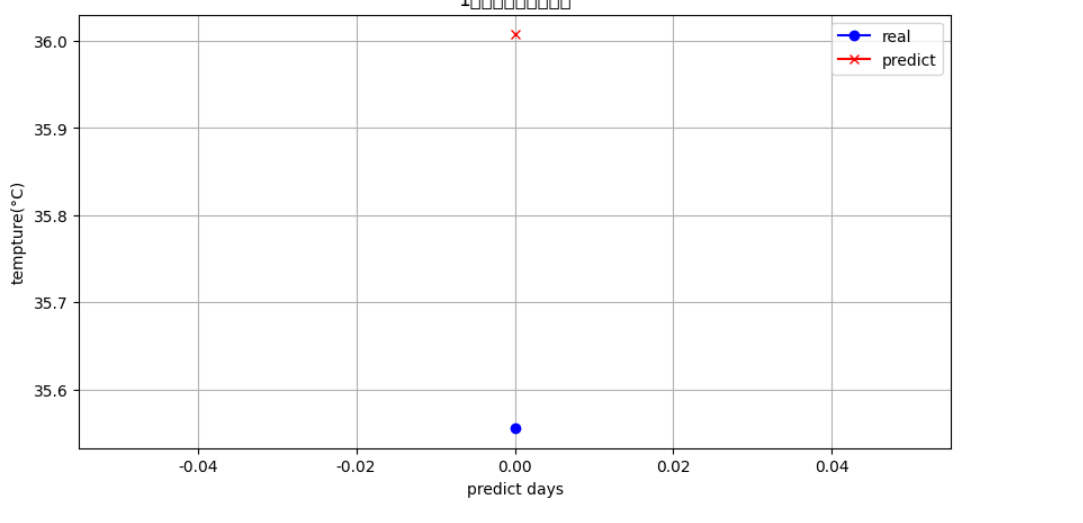

五天预测结果：

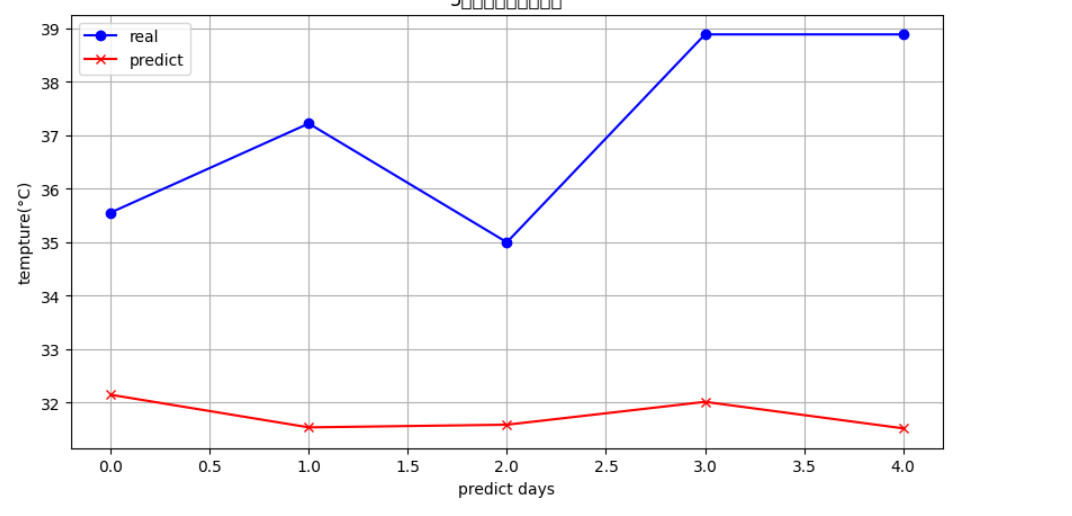


训练过程：

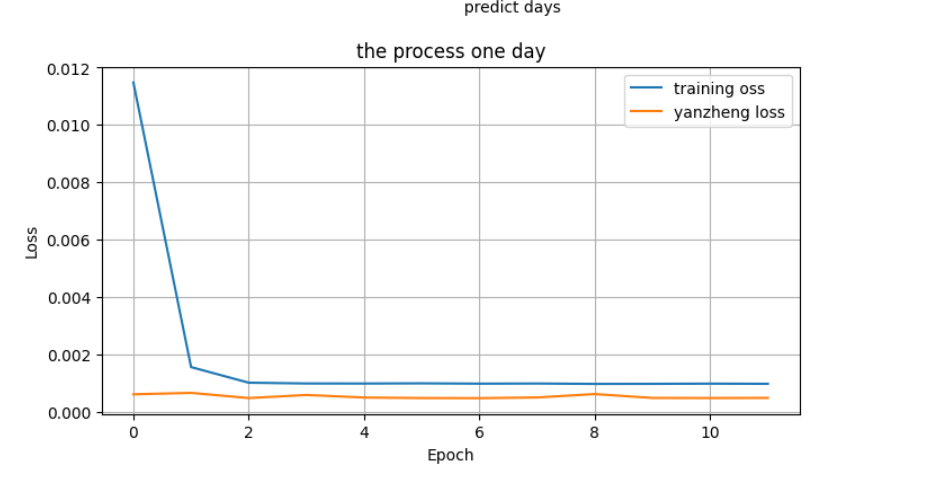


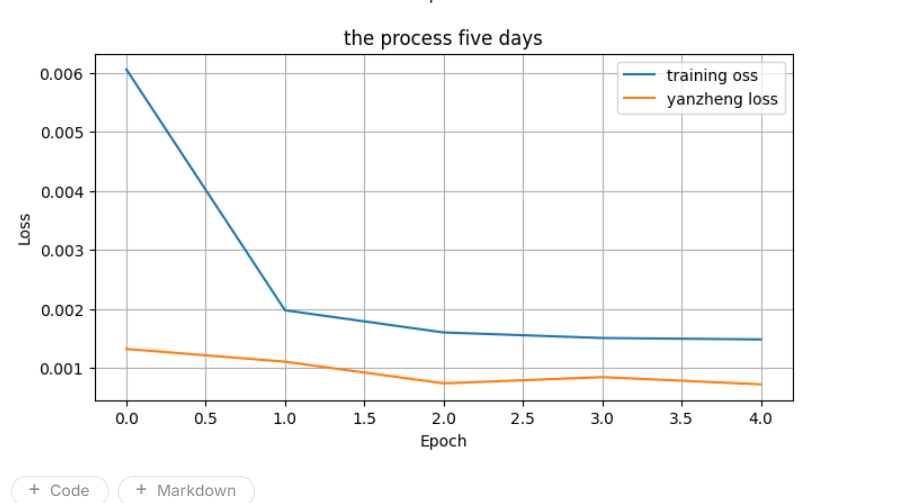